# Dependencies

In [316]:
import pandas as pd
import pdb
import seaborn as sns
import numpy as np
import math

%matplotlib inline

# Input data

In [317]:
DF=pd.read_csv('/Users/ernesto/Downloads/Computational_analysis.csv',sep=',',na_values="n.a.")
    
DF.shape

(122, 31)

And some information about DF:

In [318]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 31 columns):
Unnamed: 0            122 non-null int64
id                    122 non-null object
start                 122 non-null object
strat                 122 non-null object
entry                 122 non-null float64
entry_time            122 non-null object
outcome               122 non-null object
trend_i               122 non-null object
type                  122 non-null object
timeframe             122 non-null object
SL                    122 non-null float64
TP                    122 non-null float64
SR                    122 non-null float64
length_candles        122 non-null int64
length_pips           122 non-null int64
n_rsibounces          122 non-null int64
rsibounces_lengths    122 non-null object
bounces               122 non-null int64
bounces_lasttime      122 non-null int64
entry_onrsi           122 non-null bool
last_time             122 non-null object
slope            

* Conversion to right types<br>
Let's convert now the `last time 1st peak` variables to DateTime

In [319]:
DF['entry_time']= pd.to_datetime(DF['entry_time'])
DF['start'] = pd.to_datetime(DF['start'])
DF['trend_i']= pd.to_datetime(DF['trend_i'])
DF['last_time']= pd.to_datetime(DF['last_time'])

## Transforming

Modify the NaN values by 0

In [320]:
DF["divergence"].fillna(0, inplace=True)

In [321]:
transl_dict={ 
        'S':1,
        'F':0,
        'success' : 1,
        'failure' : 0,
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''

    return transl_dict[x[name]]

DF['outcome']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='outcome')
DF['divergence']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='divergence')
DF['entry_onrsi']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry_onrsi')

## Proportion of outcome

In [322]:
outcome_ix=6
DF.iloc[:,outcome_ix].value_counts()

1    84
0    38
Name: outcome, dtype: int64

### last time
This datetime variable represents the last time the price was over/below the entry price level. The first to do is to create a new datetime variable representing the difference (in days) between the entry datetime (start column) and the last time datetime.

In [323]:
DF['diff']=(DF['start']-DF['last_time'])

In [324]:
DF['diff']=DF['diff'].apply(lambda x: x.days)

Now, let's examine the distribution of this newly created `diff` variable in the 2 `outcome` categories

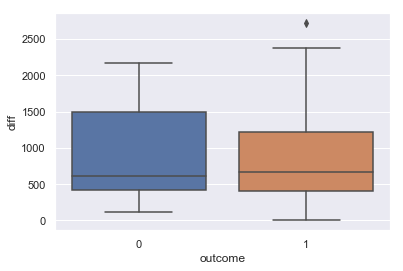

In [325]:
ax = sns.boxplot(x="outcome", y="diff", data=DF)

* Mean for each category

In [326]:
DF.groupby("outcome").agg({'diff': 'mean'})

,diff
outcome,
0,875.605263
1,886.202381


* Median for each category

In [327]:
DF.groupby("outcome").agg({'diff': 'median'})

,diff
outcome,
0,612.5
1,664.0


#### Binning data

Let's bin the data into a certain number of categories

In [338]:
max_v=max(DF['diff'])

custom_bins_array = np.arange(0, max_v, 400)

DF['diff_cat']=pd.cut(DF['diff'], np.around(custom_bins_array))

##### outcome

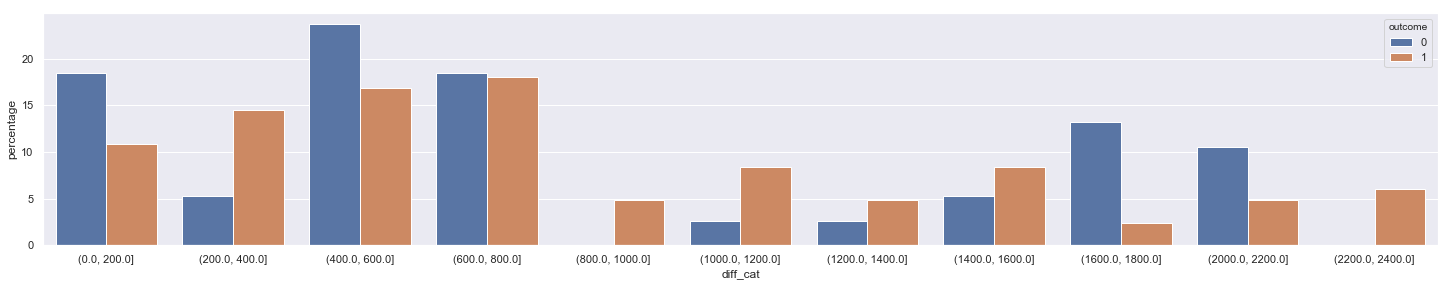

In [337]:
DF_counts = (DF.groupby(['outcome'])['diff_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('diff_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="diff_cat", y="percentage", hue='outcome', data=DF_counts)

* Conclusion  
Trades need to have at least `last time`>600 days

### n_rsibounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

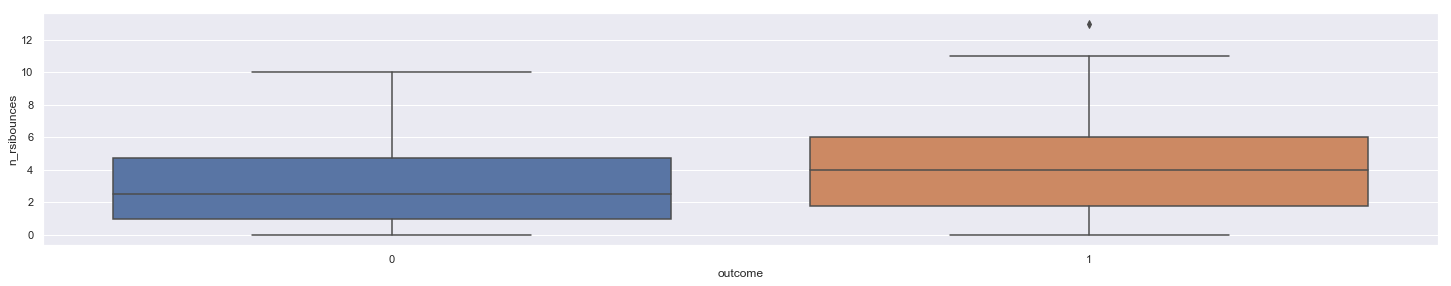

In [339]:
ax = sns.boxplot(x="outcome", y="n_rsibounces", data=DF)

* Mean for each category

In [340]:
DF.groupby("outcome").agg({"n_rsibounces": "mean"})

,n_rsibounces
outcome,
0,3.368421
1,4.083333


* Median for each category

In [342]:
medianBounce=DF.groupby("outcome").agg({"n_rsibounces": "median"})
print(medianBounce)

         n_rsibounces
outcome              
0                 2.5
1                 4.0


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

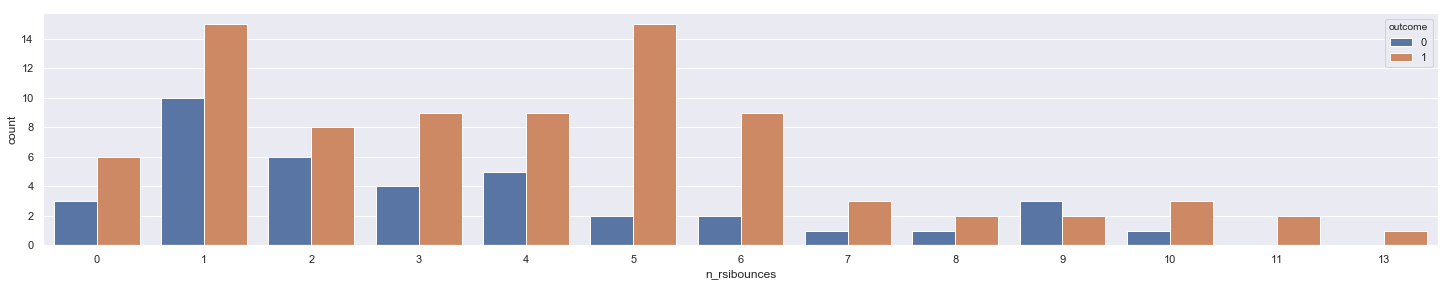

In [343]:
ax = sns.countplot(x="n_rsibounces",hue="outcome", data=DF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variable are imbalanced

##### outcome

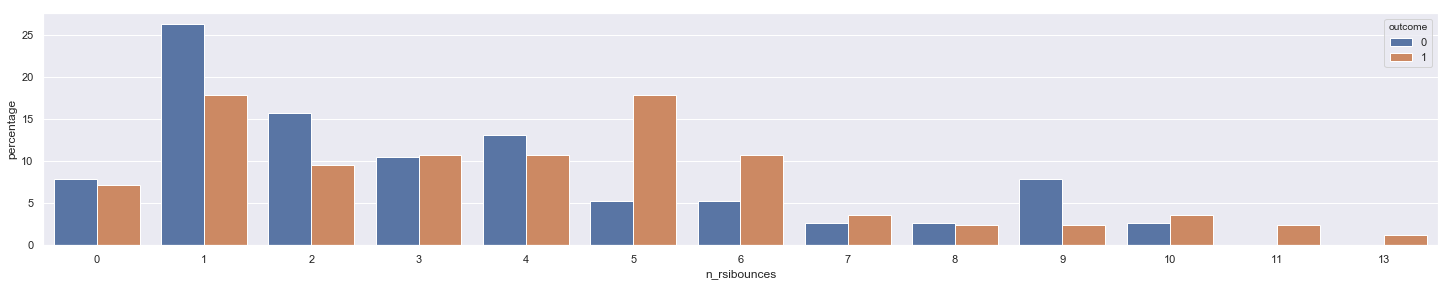

In [344]:
DF_counts = (DF.groupby(["outcome"])["n_rsibounces"]
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values("n_rsibounces"))

p = sns.barplot(x="n_rsibounces", y="percentage", hue="outcome", data=DF_counts)

* Histogram

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 1.0, 'Hist for RSI bounces on the outcome')

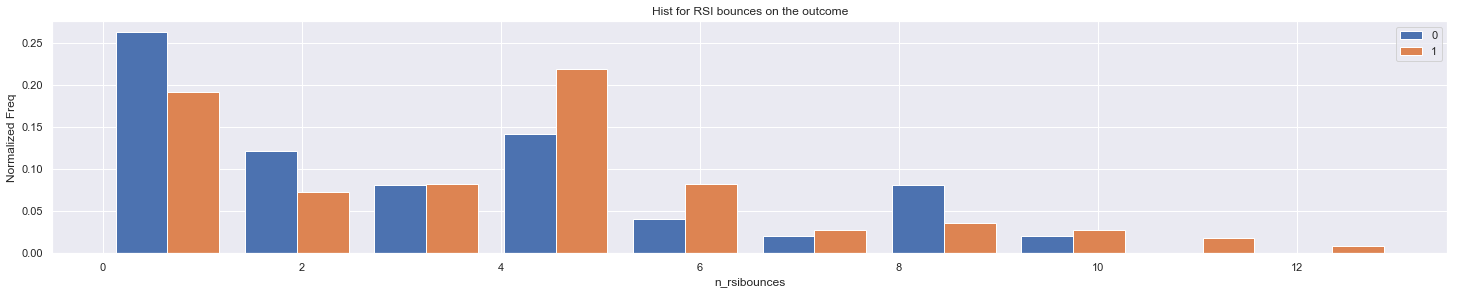

In [345]:
import matplotlib.pyplot as plt

succ=DF.loc[DF["outcome"]==1]['n_rsibounces']
fail=DF.loc[DF["outcome"]==0]['n_rsibounces']

plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('n_rsibounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for RSI bounces on the outcome')

* Conclusion  
Trades need to have at least 5 rsi bounces

### rsi_1st
This numerical variable represents the value of the RSI indicator for the 1st peak. It will be 1 if the value is in overbought/oversold region (>70 or <30 respectively) and 0 otherwise.

Let's check if `outcome` is conditioned by `rsi_1st`:

In [346]:
div_class=pd.crosstab(DF.loc[:,"outcome"], DF['rsi_1st'],margins=True)
print(div_class)

rsi_1st  False  True  All
outcome                  
0           13    25   38
1           21    63   84
All         34    88  122


In [347]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

rsi_1st       False        True         All
outcome                                    
0         38.235294   28.409091   31.147541
1         61.764706   71.590909   68.852459
All      100.000000  100.000000  100.000000


### rsi_2nd
This numerical variable represents the value of the RSI indicator for the 2nd peak. It will be 1 if the value is in overbought/oversold region (>70 or <30 respectively) and 0 otherwise.

Let's check if `outcome` is conditioned by `rsi_2nd`:

In [262]:
div_class=pd.crosstab(DF.loc[:,"outcome"], DF['rsi_2nd'],margins=True)
print(div_class)

rsi_2nd  False  True  All
outcome                  
0           38     4   42
1           67    13   80
All        105    17  122


In [263]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

rsi_2nd       False        True        All
outcome                                   
0         36.190476   23.529412   34.42623
1         63.809524   76.470588   65.57377
All      100.000000  100.000000  100.00000


### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [264]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    if x=="[]":
        return 0
    else:
        x=x.replace('[','').replace(']','').replace(' ','')
        return sum([int(i) for i in x.split(",")])
    

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [265]:
DF['sum_bounces']=DF['rsibounces_lengths'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

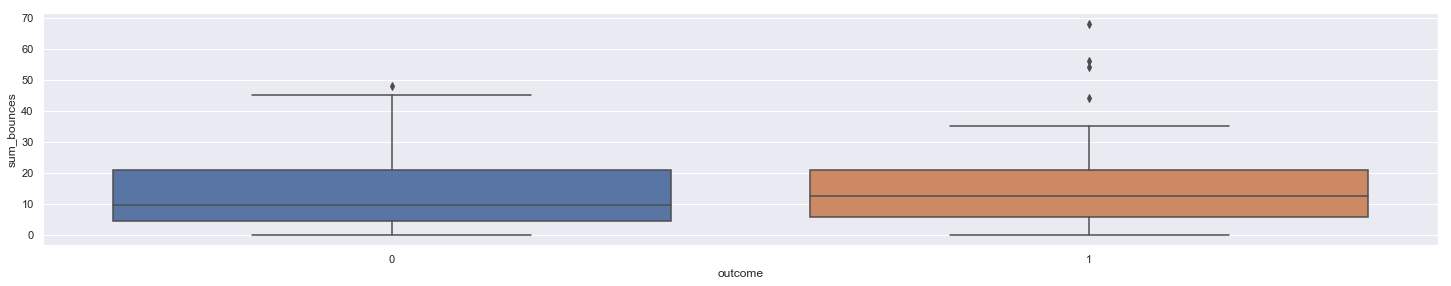

In [266]:
ax = sns.boxplot(x="outcome", y="sum_bounces", data=DF)

* Mean for each category

In [267]:
DF.groupby("outcome").agg({'sum_bounces': 'mean'})

,sum_bounces
outcome,
0,14.880952
1,15.275000


* Median for each category

In [268]:
DF.groupby("outcome").agg({'sum_bounces': 'median'})

,sum_bounces
outcome,
0,9.5
1,12.5


* Histogram

In [269]:
succ=DF.loc[DF["outcome"]==1]['sum_bounces']
fail=DF.loc[DF["outcome"]==0]['sum_bounces']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 1.0, 'Hist for sum_bounces depending on the outcome')

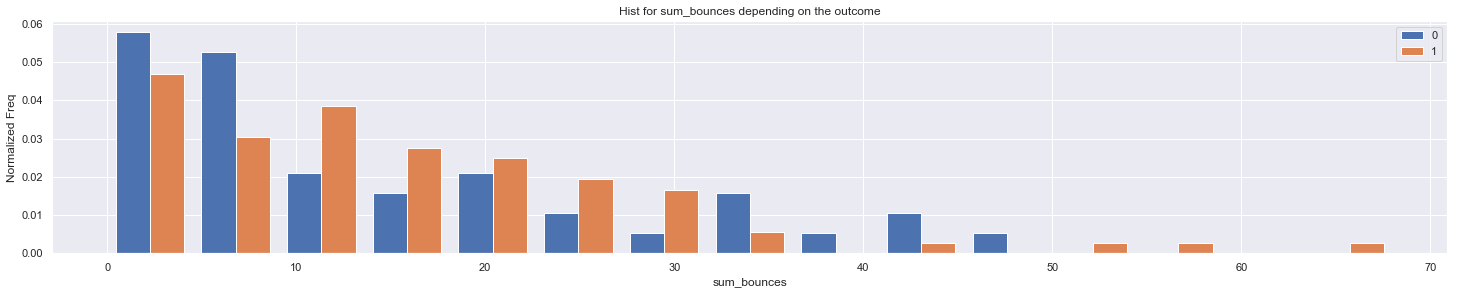

In [270]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('sum_bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for sum_bounces depending on the outcome')

#### Binning data
Let's bin the data into a certain number of categories

In [271]:
max_v=max(DF['sum_bounces'])

custom_bins_array = np.arange(0, max_v, 5)

DF['sum_bounces_cat']=pd.cut(DF['sum_bounces'], np.around(custom_bins_array))

##### outcome

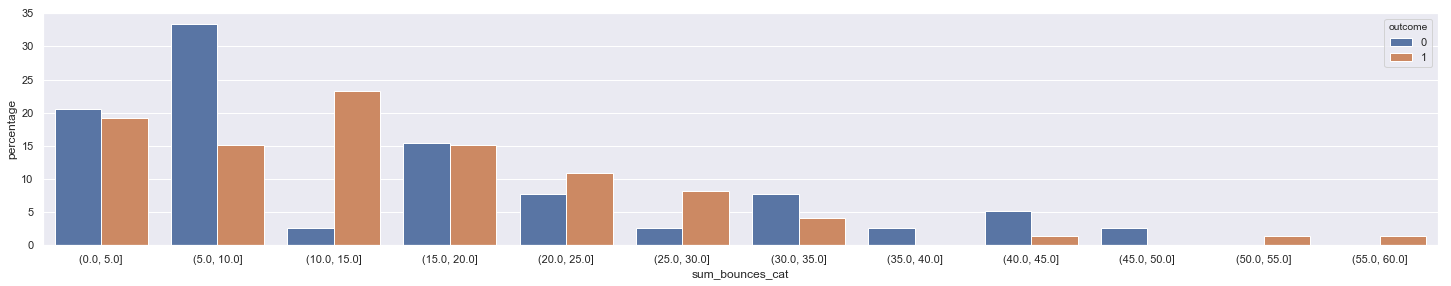

In [272]:
DF_counts = (DF.groupby(['outcome'])['sum_bounces_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('sum_bounces_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="sum_bounces_cat", y="percentage", hue='outcome', data=DF_counts)

### divergence

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [273]:
div_class=pd.crosstab(DF.loc[:,"outcome"], DF['divergence'],margins=True)
print(div_class)

divergence   0   1  All
outcome                
0           26  16   42
1           54  26   80
All         80  42  122


It's is easier to visualize the relationship if we calculate the percentages:

In [274]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

divergence      0           1        All
outcome                                 
0            32.5   38.095238   34.42623
1            67.5   61.904762   65.57377
All         100.0  100.000000  100.00000


### length_candles
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable:

#### outcome

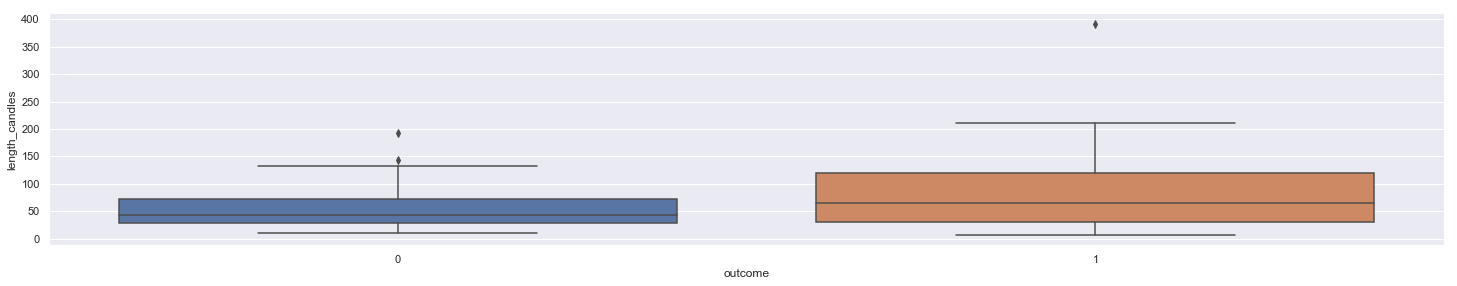

In [275]:
ax = sns.boxplot(x="outcome", y="length_candles", data=DF)

Let's analyze the distribution with a histogram

In [276]:
succ=DF.loc[DF["outcome"]==1]['length_candles']
fail=DF.loc[DF["outcome"]==0]['length_candles']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 1.0, 'Hist for Length of the trend depending on the outcome')

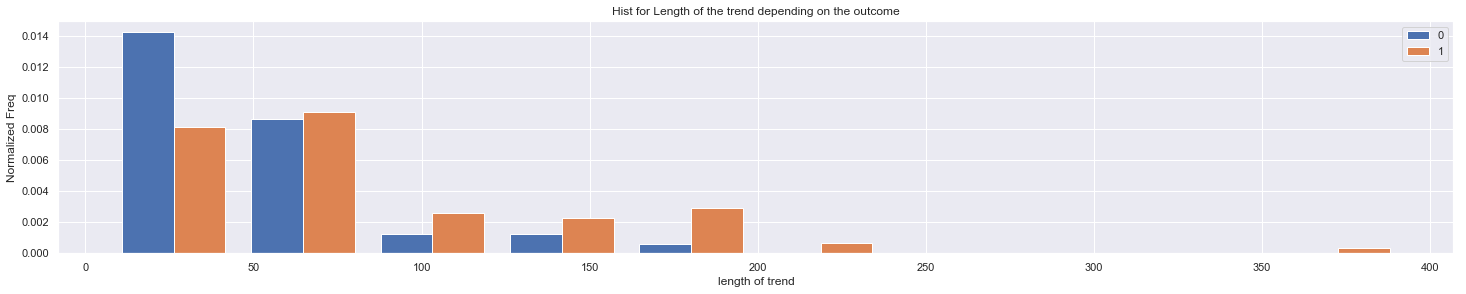

In [277]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

* Mean for each category

In [278]:
DF.groupby("outcome").agg({'length_candles': 'mean'})

,length_candles
outcome,
0,53.857143
1,84.437500


* Median for each category

In [279]:
DF.groupby("outcome").agg({'length_candles': 'median'})

,length_candles
outcome,
0,42.5
1,65.0


#### Binning data
Let's bin the data into a certain number of categories

In [280]:
max_v=max(DF['length_candles'])

custom_bins_array = np.arange(0, max_v, 40)

DF['length of trend peak_cat']=pd.cut(DF['length_candles'], np.around(custom_bins_array))

##### outcome

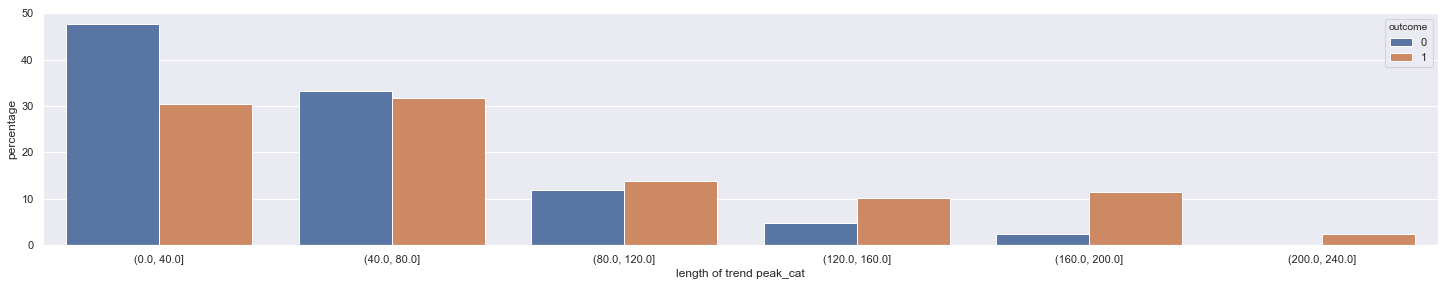

In [281]:
DF_counts = (DF.groupby(['outcome'])['length of trend peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('length of trend peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="length of trend peak_cat", y="percentage", hue='outcome', data=DF_counts)

### Pips_ratio
This variable contains the ratio between 'length of trend 1st peak'/'length in pips'

In [282]:
DF['pips_ratio']=DF['length_pips'].astype(int)/DF['length_candles'].astype(int)

And the relationship between the `pips_ratio` and the outcome is:
#### outcome

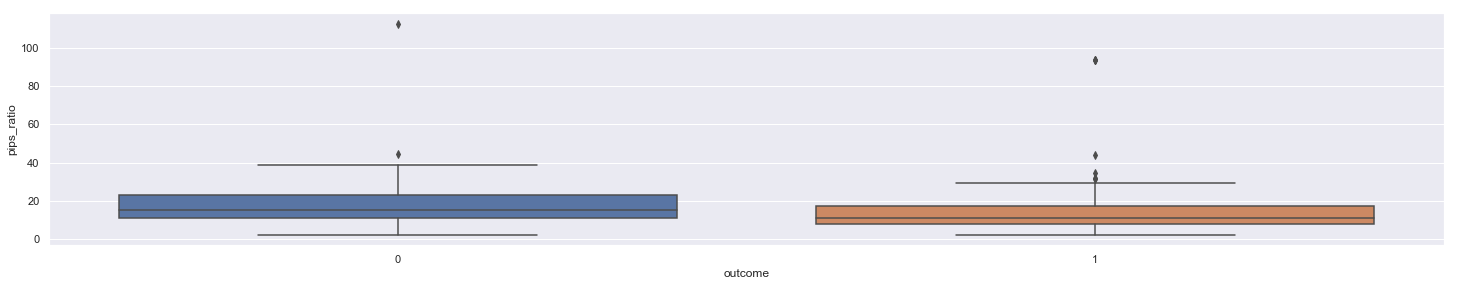

In [283]:
ax = sns.boxplot(x="outcome", y="pips_ratio", data=DF)

* Mean for each category

In [284]:
DF.groupby("outcome").agg({'pips_ratio': 'mean'})

,pips_ratio
outcome,
0,19.816751
1,16.322329


* Median for each category

In [285]:
DF.groupby("outcome").agg({'pips_ratio': 'median'})

,pips_ratio
outcome,
0,15.558621
1,11.277083


Let's analyze the distribution with a histogram

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 1.0, 'Hist for Pips ratio on the outcome')

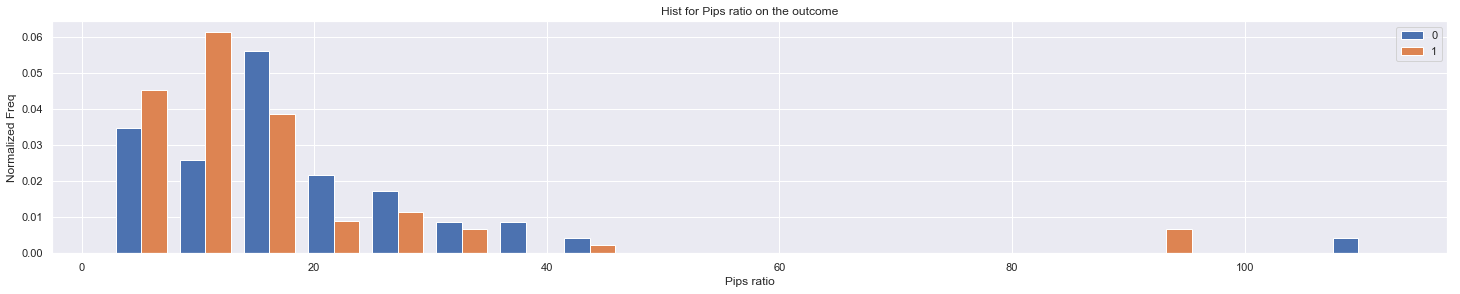

In [286]:
succ=DF.loc[DF["outcome"]==1]['pips_ratio']
fail=DF.loc[DF["outcome"]==0]['pips_ratio']

plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome')

#### Binning data
Let's bin the data into a certain number of categories

In [287]:
max_v=max(DF['pips_ratio'])

custom_bins_array = np.arange(0, max_v, 50)

DF['pips_ratio_cat']=pd.cut(DF['pips_ratio'], np.around(custom_bins_array))

##### outcome

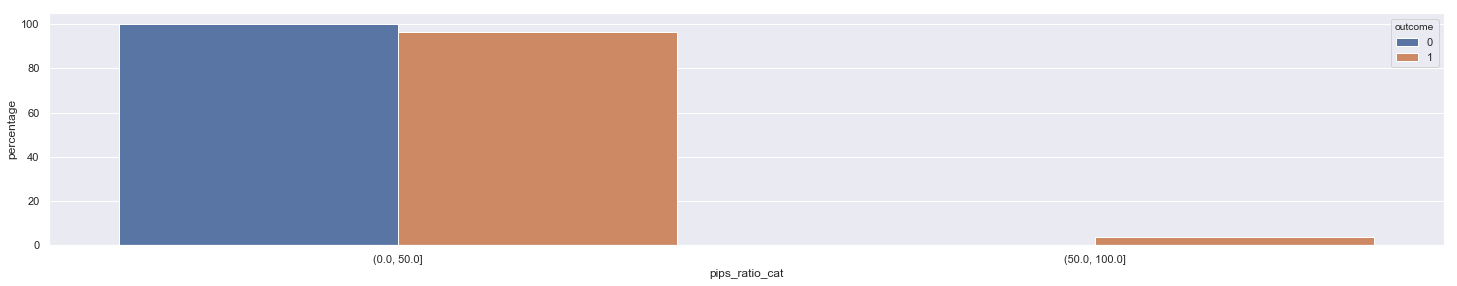

In [288]:
DF_counts = (DF.groupby(['outcome'])['pips_ratio_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('pips_ratio_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="pips_ratio_cat", y="percentage", hue='outcome', data=DF_counts)

### bounces
This quantitative discrete variable is used for representing the number of times the price has tested this level. Let's start comparing the distribution of this variable for the different categories of the outcome variable.

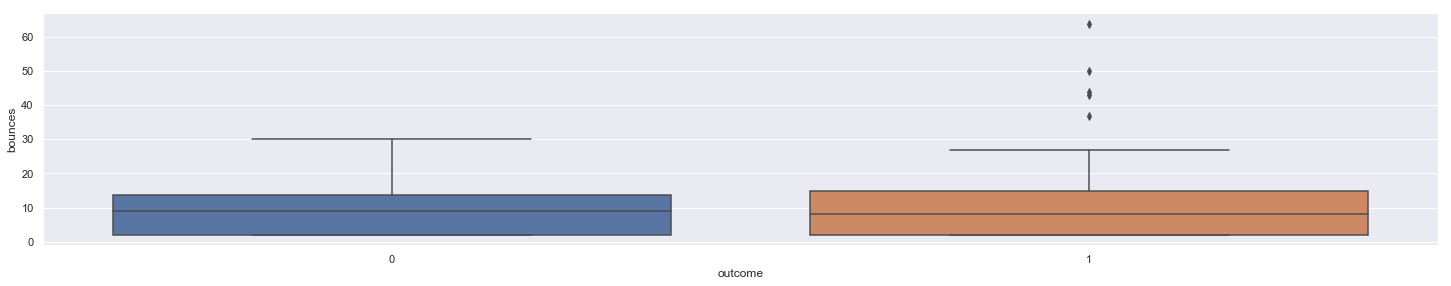

In [289]:
ax = sns.boxplot(x="outcome", y="bounces", data=DF)

* Mean for each category

In [290]:
DF.groupby("outcome").agg({'bounces': 'mean'})

,bounces
outcome,
0,9.571429
1,11.562500


* Median for each category

In [291]:
DF.groupby("outcome").agg({'bounces': 'median'})

,bounces
outcome,
0,9
1,8


#### Binning data
Let's bin the data into a certain number of categories

In [292]:
max_v=max(DF['bounces'])

custom_bins_array = np.arange(0, max_v, 1)

DF['bounces peak_cat']=pd.cut(DF['bounces'], np.around(custom_bins_array))

##### outcome

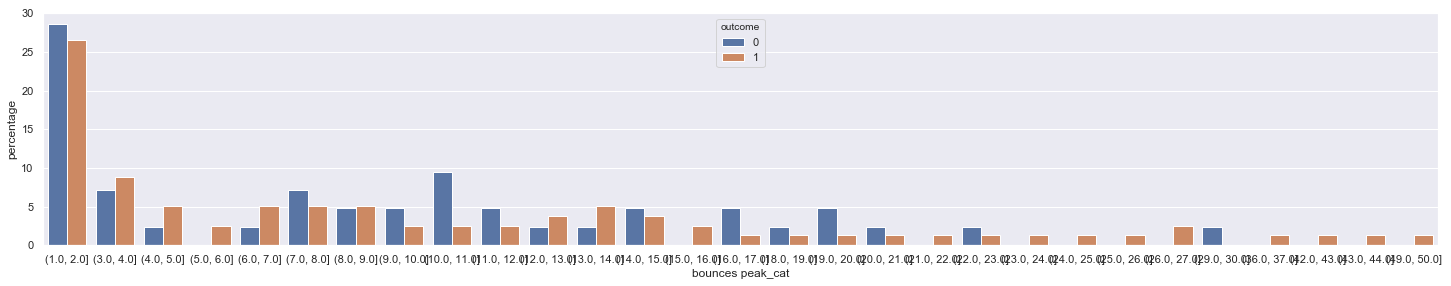

In [293]:
DF_counts = (DF.groupby(['outcome'])['bounces peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('bounces peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="bounces peak_cat", y="percentage", hue='outcome', data=DF_counts)

### bounces_lasttime
This quantitative discrete variable is used for representing the number of times the price has tested this level since `last_time`. Let's start comparing the distribution of this variable for the different categories of the outcome variable.

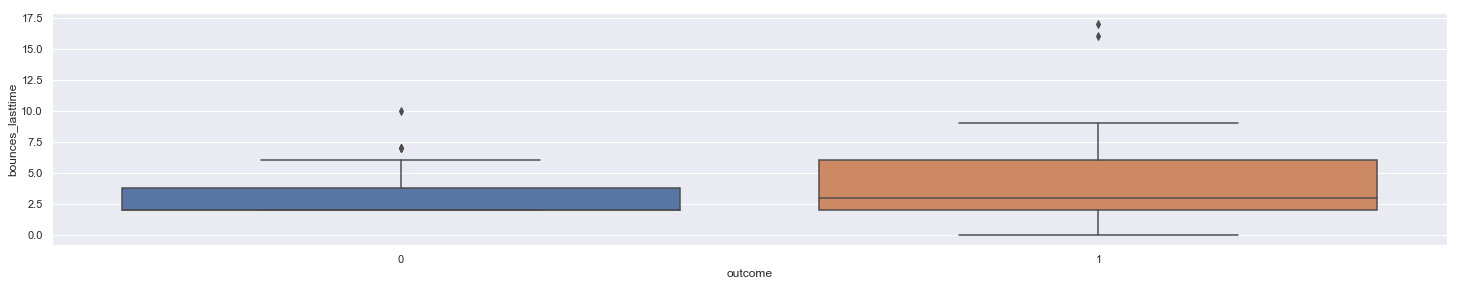

In [313]:
ax = sns.boxplot(x="outcome", y="bounces_lasttime", data=DF)

* Mean for each category

In [290]:
DF.groupby("outcome").agg({'bounces_lasttime': 'mean'})

,bounces
outcome,
0,9.571429
1,11.562500


* Median for each category

In [291]:
DF.groupby("outcome").agg({'bounces_lasttime': 'median'})

,bounces
outcome,
0,9
1,8


#### Binning data
Let's bin the data into a certain number of categories

In [314]:
max_v=max(DF['bounces_lasttime'])

custom_bins_array = np.arange(0, max_v, 1)

DF['bounces peak_cat']=pd.cut(DF['bounces_lasttime'], np.around(custom_bins_array))

##### outcome

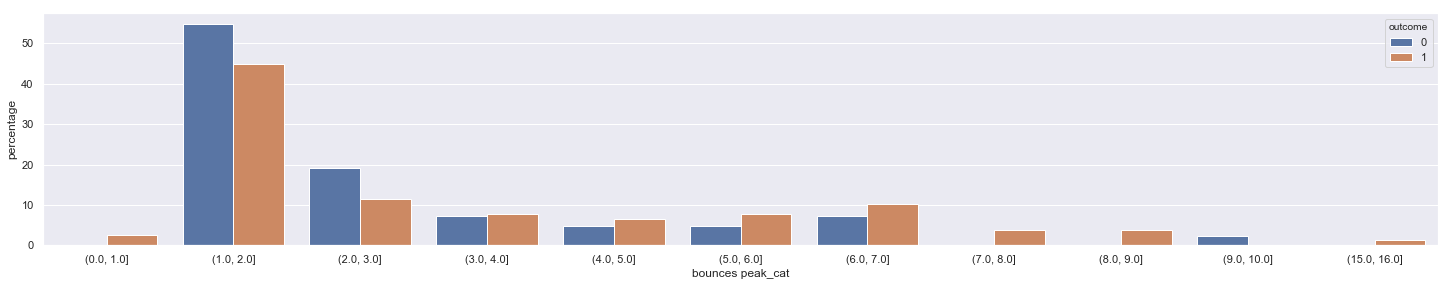

In [315]:
DF_counts = (DF.groupby(['outcome'])['bounces peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('bounces peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="bounces peak_cat", y="percentage", hue='outcome', data=DF_counts)

###  valley
Is a quantitative numerical variable representing the number of candles between the first and the second peak.
Let's examine the distribution of `valley` depending on `outcome`

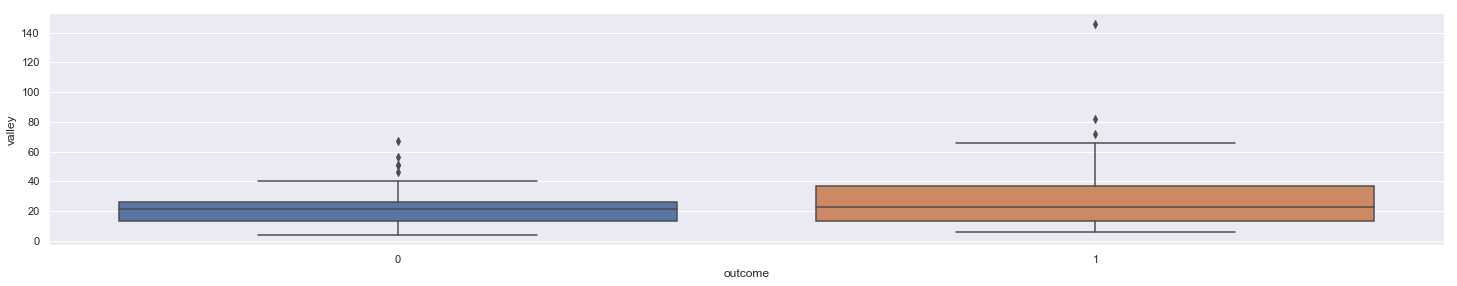

In [294]:
ax = sns.boxplot(x="outcome", y="valley", data=DF)

* Mean for each category

In [295]:
DF.groupby("outcome").agg({'valley': 'mean'})

,valley
outcome,
0,23.02381
1,28.12500


* Median for each category

In [296]:
DF.groupby("outcome").agg({'valley': 'median'})

,valley
outcome,
0,21.0
1,22.5


* Histogram

In [297]:
succ=DF.loc[DF["outcome"]==1]['valley']
fail=DF.loc[DF["outcome"]==0]['valley']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 1.0, 'Hist for valley depending on the outcome of the 2nd peak')

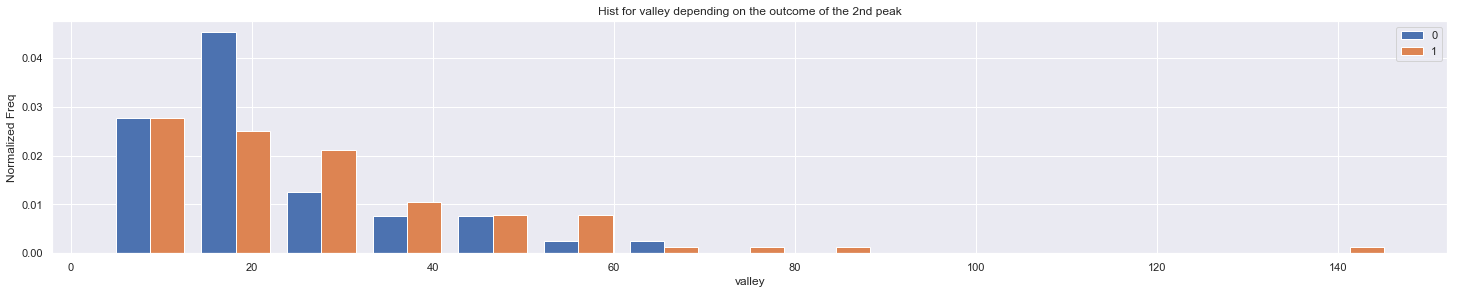

In [298]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('valley')
plt.ylabel('Normalized Freq')
plt.title('Hist for valley depending on the outcome of the 2nd peak')

#### Binning data
Let's bin the data into a certain number of categories

In [299]:
max_v=max(DF['valley'])

custom_bins_array = np.arange(0, max_v, 10)

DF['valley_cat']=pd.cut(DF['valley'], np.around(custom_bins_array))

##### outcome 2nd peak

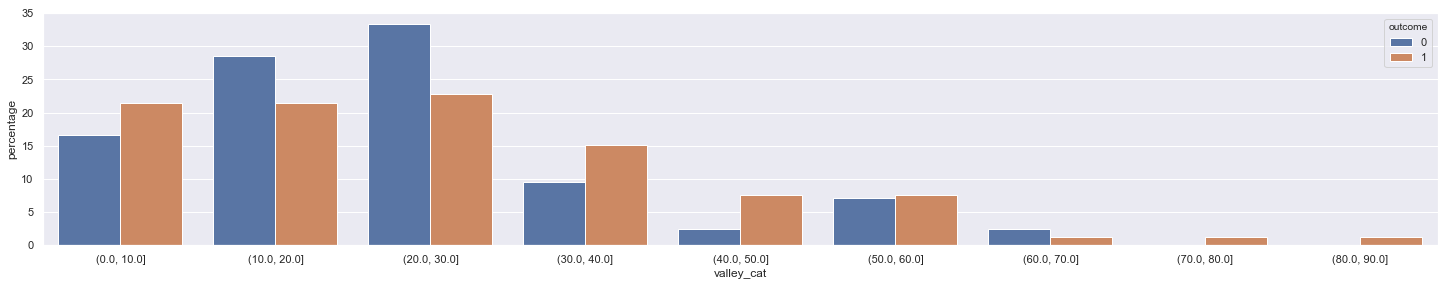

In [301]:
DF_counts = (DF.groupby(['outcome'])['valley_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('valley_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="valley_cat", y="percentage", hue='outcome', data=DF_counts)

### diff
Quantitative variable representing the difference between rsi_1st & rsi_2nd

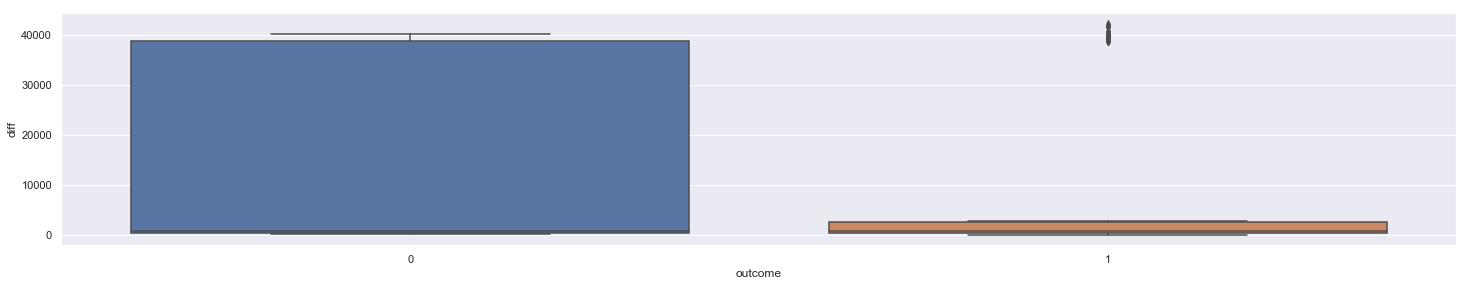

In [304]:
ax = sns.boxplot(x="outcome", y="diff", data=DF)

* Mean for each category

In [306]:
DF.groupby("outcome").agg({'diff': 'mean'})

,diff
outcome,
0,12659.071429
1,9973.187500


* Median for each category

In [307]:
DF.groupby("outcome").agg({'diff': 'median'})

,diff
outcome,
0,762.5
1,700.0


* Histogram

In [308]:
succ=DF.loc[DF["outcome"]==1]['diff']
fail=DF.loc[DF["outcome"]==0]['diff']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 1.0, 'Hist for differential depending on the outcome')

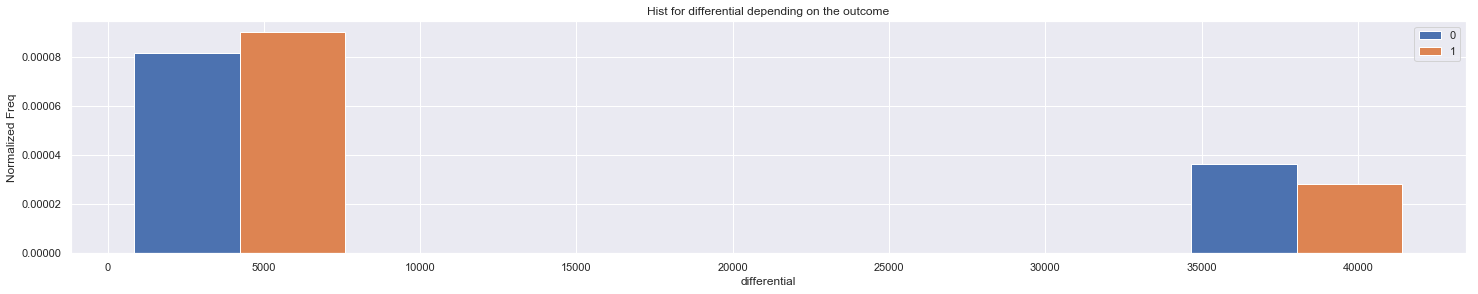

In [309]:
plt.hist([fail,succ], bins = 5, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('differential')
plt.ylabel('Normalized Freq')
plt.title('Hist for differential depending on the outcome')

#### Binning data
Let's bin the data into a certain number of categories

In [310]:
max_v=max(DF['diff'])

custom_bins_array = np.arange(0, max_v, 100)

DF['diff_cat']=pd.cut(DF['diff'], np.around(custom_bins_array))